# Inverter Parameters Calculation

Based on:
- https://onlinelibrary.wiley.com/doi/abs/10.1002/cta.2628
- https://ieeexplore.ieee.org/document/9385387

## Architecture and specifications to be met


### Architecture:
![Capture d’écran 2024-03-18 à 11.00.11.png](<attachment:Capture d’écran 2024-03-18 à 11.00.11.png>)
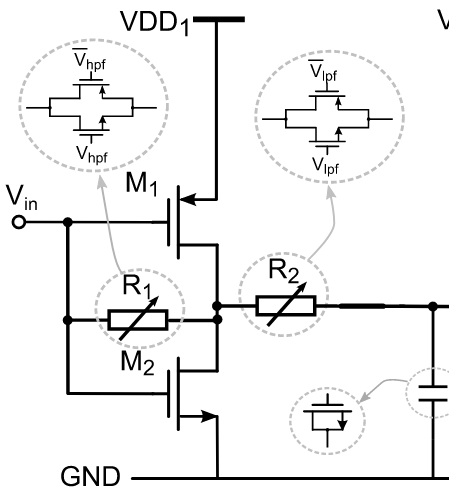

### Condition

$V_{DD} > V_{thn} + \left| V_{thp} \right|$ avoid hysteric VTC

### Specifications:

- Power supply voltage: between 0.5V and 1.5V
- Input-referred noise: below 3uV between 300Hz and 10kHz
- Gain: above 20dB
- Frequency response: bandpass with flat gain between 10Hz and 5kHz
- Power consumption: below 10uW


### Technology specifications:

https://skywater-pdk.readthedocs.io/en/main/rules/device-details.html#details

# Calculation:

## Add libraries and variables

In [2]:
import numpy as np
import sympy
import matplotlib.pyplot as plt

Vdd = 1                         # [V]   Power supply voltage
Vth = 0.4                       # [V]   Threshold voltage

## Biasing

![Fig6-VTC-CMOS Inverter.png](<attachment:Fig6-VTC-CMOS Inverter.png>)
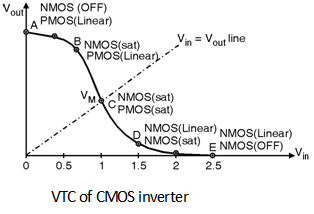

We'll bias the NMOS and PMOS transistors in saturation where Vin = Vout for maximum gain in our open-loop amplifier configuration. The total transconductance, gm (representing the gain), is approximated by the sum of the NMOS (gmn) and PMOS (gmp) transconductances. This approach presumes minimal impact from parasitic elements.

In [1]:
gm, gmn, gmp = sp.symbols('gmn gmp gm')
gm = gmn + gmp

NameError: name 'sp' is not defined